In [1]:
"""
🎭 MODELO CNN MEJORADO PARA RECONOCIMIENTO DE EMOCIONES FACIALES
===============================================================
Versión optimizada para alcanzar 80%+ accuracy
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("🚀 MODELO CNN MEJORADO - TARGET 80%+ ACCURACY")
print("=" * 60)

🚀 MODELO CNN MEJORADO - TARGET 80%+ ACCURACY


In [3]:
# =============================================================================
# 1. ⚙️ CONFIGURACIÓN AVANZADA
# =============================================================================

print("🔧 Configurando entorno optimizado...")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
            )
        print("✅ GPU configurada con límite de memoria")
    except RuntimeError as e:
        print(f"❌ Error configurando GPU: {e}")

# Parámetros optimizados
PARAMS = {
    'data_path': r"C:\Users\maria\OneDrive\Documentos\AnotherSigma\PONTIA\PROYECTO JUPITER\archive",
    'img_size': 48,
    'batch_size': 32,
    'epochs': 40,  # Reducido a 40 como el modelo anterior
    'learning_rate': 0.0003,
    'random_state': 42
}

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(EMOTIONS)

CLASS_DISTRIBUTION = {
    'angry': 3983, 'disgust': 436, 'fear': 4097, 'happy': 7217,
    'neutral': 4967, 'sad': 4838, 'surprise': 3371
}

print(f"🎯 Target: 80%+ accuracy")
print(f"📊 Enfoque: Arquitectura Simplificada + Adam")

# Verificar rutas
train_path = os.path.join(PARAMS['data_path'], 'train')
test_path = os.path.join(PARAMS['data_path'], 'test')

if not os.path.exists(train_path) or not os.path.exists(test_path):
    print("❌ Error: Verificar rutas de datos")
    exit()

🔧 Configurando entorno optimizado...
🎯 Target: 80%+ accuracy
📊 Enfoque: Arquitectura Simplificada + Adam


In [4]:
# =============================================================================
# 2. 📊 GENERADORES DE DATOS
# =============================================================================

print("\n📊 CONFIGURANDO GENERADORES...")

# Aumentación como el modelo anterior
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Sin aumentación para validación/prueba
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(PARAMS['img_size'], PARAMS['img_size']),
    batch_size=PARAMS['batch_size'],
    class_mode='sparse',
    color_mode='grayscale',
    shuffle=True,
    seed=PARAMS['random_state']
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(PARAMS['img_size'], PARAMS['img_size']),
    batch_size=PARAMS['batch_size'],
    class_mode='sparse',
    color_mode='grayscale',
    shuffle=False
)

print(f"✅ Entrenamiento: {train_generator.samples} imágenes")
print(f"✅ Prueba: {test_generator.samples} imágenes")


📊 CONFIGURANDO GENERADORES...
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Entrenamiento: 28709 imágenes
✅ Prueba: 7178 imágenes


In [5]:
# =============================================================================
# 3. ⚖️ SISTEMA DE PESOS
# =============================================================================

print("\n⚖️ CALCULANDO PESOS OPTIMIZADOS...")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("📊 Pesos optimizados por clase:")
for i, emotion in enumerate(EMOTIONS):
    print(f"   {emotion}: {class_weights_dict[i]:.3f}")


⚖️ CALCULANDO PESOS OPTIMIZADOS...
📊 Pesos optimizados por clase:
   angry: 1.027
   disgust: 9.407
   fear: 1.001
   happy: 0.568
   neutral: 0.826
   sad: 0.849
   surprise: 1.293


In [6]:
# =============================================================================
# 4. 🏗️ ARQUITECTURA CNN
# =============================================================================

print("\n🏗️ CONSTRUYENDO ARQUITECTURA...")

def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

model = create_cnn()
print("🏛️ Arquitectura creada")
model.summary()


🏗️ CONSTRUYENDO ARQUITECTURA...
🏛️ Arquitectura creada
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       256       
 hNormalization)                                                 


In [7]:
# =============================================================================
# 5. 🔧 COMPILACIÓN
# =============================================================================

print("\n🔧 COMPILANDO CON OPTIMIZADOR ADAM...")

model.compile(
    optimizer=Adam(learning_rate=PARAMS['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo compilado con optimizador Adam")


🔧 COMPILANDO CON OPTIMIZADOR ADAM...
✅ Modelo compilado con optimizador Adam


In [8]:
# =============================================================================
# 6. 📋 CALLBACKS
# =============================================================================

print("\n📋 CONFIGURANDO CALLBACKS...")

model_checkpoint = ModelCheckpoint(
    'best_emotion_model_v2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [model_checkpoint, early_stopping, reduce_lr]
print("✅ Callbacks configurados")


📋 CONFIGURANDO CALLBACKS...
✅ Callbacks configurados


In [9]:
# =============================================================================
# 7. 🚀 ENTRENAMIENTO
# =============================================================================

print("\n🚀 INICIANDO ENTRENAMIENTO...")
print("🎯 Target: 80%+ accuracy")
print("=" * 50)

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // PARAMS['batch_size'],
        epochs=PARAMS['epochs'],
        validation_data=test_generator,
        validation_steps=test_generator.samples // PARAMS['batch_size'],
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )
    print("\n✅ Entrenamiento completado!")
except KeyboardInterrupt:
    print("\n⚠️ Entrenamiento interrumpido")


🚀 INICIANDO ENTRENAMIENTO...
🎯 Target: 80%+ accuracy
Epoch 1/40
897/897 [==============================] - ETA: 0s - loss: 17.9412 - accuracy: 0.1719   
Epoch 1: val_accuracy improved from -inf to 0.25698, saving model to best_emotion_model_v2.h5
897/897 [==============================] - 435s 483ms/step - loss: 17.9412 - accuracy: 0.1719 - val_loss: 12.4865 - val_accuracy: 0.2570 - lr: 3.0000e-04
Epoch 2/40
897/897 [==============================] - ETA: 0s - loss: 9.6013 - accuracy: 0.2099   
Epoch 2: val_accuracy did not improve from 0.25698
897/897 [==============================] - 431s 480ms/step - loss: 9.6013 - accuracy: 0.2099 - val_loss: 6.8474 - val_accuracy: 0.1945 - lr: 3.0000e-04
Epoch 3/40
897/897 [==============================] - ETA: 0s - loss: 5.6155 - accuracy: 0.2578  
Epoch 3: val_accuracy improved from 0.25698 to 0.30050, saving model to best_emotion_model_v2.h5
897/897 [==============================] - 433s 483ms/step - loss: 5.6155 - accuracy: 0.2578 - val_lo


📈 GENERANDO ANÁLISIS...


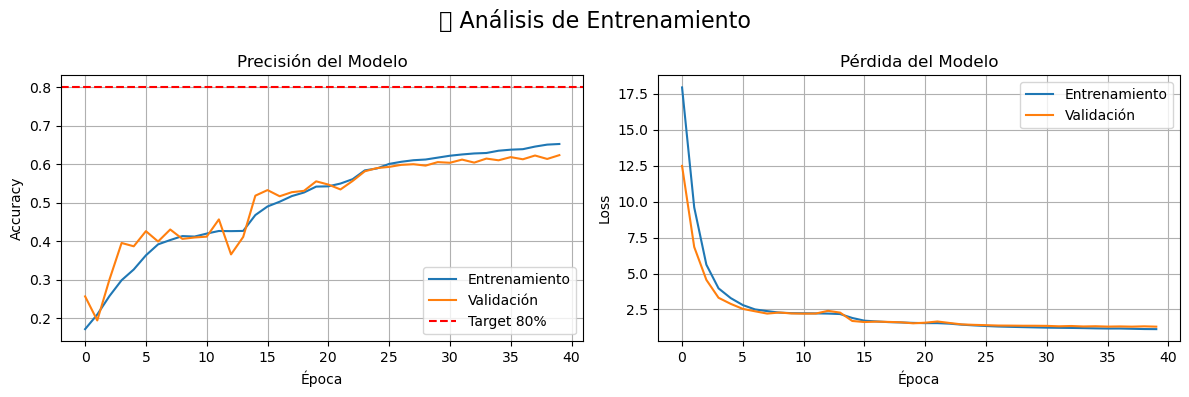

In [10]:
# =============================================================================
# 8. 📈 ANÁLISIS DE RESULTADOS
# =============================================================================

print("\n📈 GENERANDO ANÁLISIS...")

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('🎭 Análisis de Entrenamiento', fontsize=16)
    
    axes[0].plot(history.history['accuracy'], label='Entrenamiento')
    axes[0].plot(history.history['val_accuracy'], label='Validación')
    axes[0].axhline(y=0.8, color='red', linestyle='--', label='Target 80%')
    axes[0].set_title('Precisión del Modelo')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['loss'], label='Entrenamiento')
    axes[1].plot(history.history['val_loss'], label='Validación')
    axes[1].set_title('Pérdida del Modelo')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'history' in locals():
    plot_training_history(history)


🧪 EVALUACIÓN DEL MODELO...
✅ Mejor modelo cargado
225/225 [==============================] - 9s 35ms/step - loss: 1.3049 - accuracy: 0.6245

📊 RESULTADOS:
   🎯 Accuracy: 0.6245 (62.45%)
   📉 Loss: 1.3049
   ⚠️ Target 80%: NO ALCANZADO
225/225 [==============================] - 8s 32ms/step


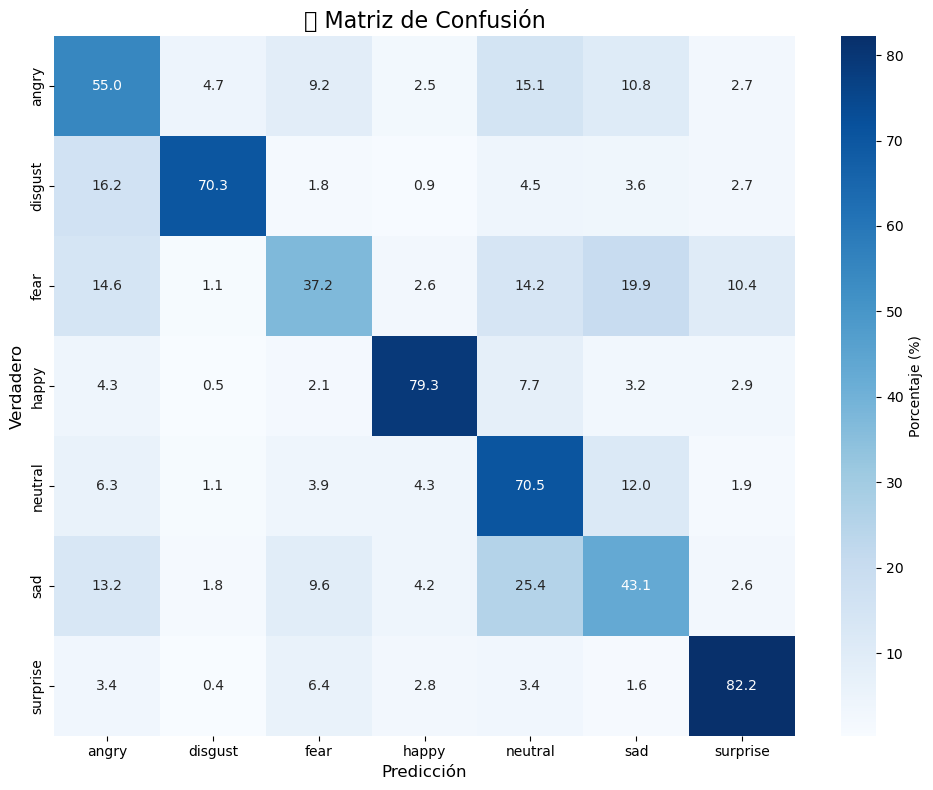


📋 REPORTE DETALLADO:
              precision    recall  f1-score   support

       angry     0.5067    0.5501    0.5275       958
     disgust     0.4286    0.7027    0.5324       111
        fear     0.5219    0.3721    0.4344      1024
       happy     0.8866    0.7931    0.8373      1774
     neutral     0.5279    0.7048    0.6037      1233
         sad     0.5047    0.4314    0.4652      1247
    surprise     0.7368    0.8219    0.7770       831

    accuracy                         0.6245      7178
   macro avg     0.5876    0.6252    0.5968      7178
weighted avg     0.6315    0.6245    0.6220      7178


📊 Weighted F1-Score: 0.6220

🎯 ANÁLISIS POR CLASE (OBJETIVO: >70% cada clase):
------------------------------------------------------------
⚠️      angry: 0.5501 (55.01%)
✅    disgust: 0.7027 (70.27%)
❌       fear: 0.3721 (37.21%)
✅      happy: 0.7931 (79.31%)
✅    neutral: 0.7048 (70.48%)
❌        sad: 0.4314 (43.14%)
✅   surprise: 0.8219 (82.19%)

📊 Accuracy promedio por clas

In [11]:
# =============================================================================
# 9. 🧪 EVALUACIÓN
# =============================================================================

print("\n🧪 EVALUACIÓN DEL MODELO...")

try:
    best_model = tf.keras.models.load_model('best_emotion_model_v2.h5')
    print("✅ Mejor modelo cargado")
except:
    best_model = model
    print("⚠️ Usando modelo actual")

test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"\n📊 RESULTADOS:")
print(f"   🎯 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   📉 Loss: {test_loss:.4f}")
print(f"   {'✅' if test_accuracy >= 0.8 else '⚠️'} Target 80%: {'ALCANZADO' if test_accuracy >= 0.8 else 'NO ALCANZADO'}")

# Predicciones
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS,
            cbar_kws={'label': 'Porcentaje (%)'})
plt.title('🎭 Matriz de Confusión', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Verdadero', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Reporte detallado
print("\n📋 REPORTE DETALLADO:")
print("=" * 60)
class_report = classification_report(
    true_classes, predicted_classes, 
    target_names=EMOTIONS, 
    digits=4
)
print(class_report)

# Calcular F1-score ponderado
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"\n📊 Weighted F1-Score: {f1:.4f}")

# Análisis por clase
print("\n🎯 ANÁLISIS POR CLASE (OBJETIVO: >70% cada clase):")
print("-" * 60)
class_accuracies = []
for i, emotion in enumerate(EMOTIONS):
    mask = true_classes == i
    if np.sum(mask) > 0:
        emotion_accuracy = np.mean(predicted_classes[mask] == i)
        class_accuracies.append(emotion_accuracy)
        status = "✅" if emotion_accuracy >= 0.7 else "⚠️" if emotion_accuracy >= 0.5 else "❌"
        print(f"{status} {emotion:>10}: {emotion_accuracy:.4f} ({emotion_accuracy*100:.2f}%)")

avg_class_acc = np.mean(class_accuracies)
print(f"\n📊 Accuracy promedio por clase: {avg_class_acc:.4f} ({avg_class_acc*100:.2f}%)")